# Training analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the training data without the helper code which was moved into the [`deepracer-utils` library](https://github.com/aws-deepracer-community/deepracer-utils).

## Training environments

Depending on whether you're running your training through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:
* AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html
* Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

* AWS DeepRacer Team for initial workbooks created for DeepRacer Workshops at Summits and re:Invent.
* [CodeLikeAMother](https://codelikeamother.uk) for initial rework of the notebook.
* [The AWS DeepRacer Community](http://join.deepracing.io) for feedback and incremental improvements.

# Log Analysis

Let's get to it.

## Installs and setups

If you are using an AWS SageMaker Notebook or Sagemaker Studio Lab to run the log analysis, you will need to ensure you install required dependencies. To do that uncomment and run the following:

In [1]:
# Make sure you have the required pre-reqs

# import sys

# !{sys.executable} -m pip install --upgrade -r requirements.txt

## Imports

Run the imports block below:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import os

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog, \
    S3FileHandler, FSFileHandler

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Login

Login to AWS. There are several ways to log in:
1. On EC2 instance or Sagemaker Notebook with correct IAM execution role assigned.
2. AWS credentials available in `.aws/` through using the `aws configure` command. (DeepRacer-for-Cloud's `dr-start-loganalysis` supports this)
3. Setting the relevant environment variables by uncommenting the below section.

In [3]:
# os.environ["AWS_DEFAULT_REGION"] = "" #<-Add your region
# os.environ["AWS_ACCESS_KEY_ID"] = "" #<-Add your access key
# os.environ["AWS_SECRET_ACCESS_KEY"] = "" #<-Add you secret access key
# os.environ["AWS_SESSION_TOKEN"] = "" #<-Add your session key if you have one

## Get the logs

Depending on which way you are training your model, you will need a slightly different way to load the data. The simplest way to read in training data is using the sim-trace files.

For other ways to read in data look at the [configuration examples](https://github.com/aws-deepracer-community/deepracer-utils/blob/master/docs/examples.md).

In [4]:
# For basic setup set prefix to exact S3 location.  For advanced setup set prefix without the hypen and number at the end e.g. for test-1, test-2 set prefix as test 
PREFIX='rl-deepracer-sagemaker'   # Name of the model, without trailing '/'
BUCKET='deepracer-thunder-compute-660ea65b-20250801-220005-99df103b'       # Bucket name is default 'bucket' when training locally
PROFILE='minio'          # The credentials profile in .aws - 'minio' for local training
S3_ENDPOINT_URL='http://minio:9000'  # Endpoint URL: None for AWS S3, 'http://minio:9000' for local training

In [5]:
fh = S3FileHandler(bucket=BUCKET, prefix=PREFIX, profile=PROFILE, s3_endpoint_url=S3_ENDPOINT_URL)
log = DeepRacerLog(filehandler=fh)
log.load_training_trace()

In [6]:
# # Example / Alternative for logs on file-system
# fh = FSFileHandler(model_folder='logs/sample-console-logs', robomaker_log_path='logs/sample-console-logs/logs/training/training-20220611230353-EHNgTNY2T9-77qXhqjBi6A-robomaker.log')
# log = DeepRacerLog(filehandler=fh)
# log.load_robomaker_logs()

In [7]:
try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Logs not available")

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '5'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.999,
 'e_greedy_value': 0.05,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0003,
 'num_episodes_between_training': 20,
 'num_epochs': 3,
 'stack_size': 3,
 'term_cond_avg_score': 100000.0,
 'term_cond_max_episodes': 100000}
-------------
[{'speed': 1.0, 'steering_angle': 0.0},
 {'speed': 1.0, 'steering_angle': -7.5},
 {'speed': 1.0, 'steering_angle': 7.5},
 {'speed': 1.0, 'steering_angle': -15.0},
 {'speed': 1.0, 'steering_angle': 15.0},
 {'speed': 1.0, 'steering_angle': -22.5},
 {'speed': 1.0, 'steering_angle': 22.5},
 {'speed': 1.0, 'steering_angle': -30.0},
 {'speed': 1.0, 'steering_angle': 30.0},
 {'speed': 2.5, 'steering_angle': 0.0},
 {'speed': 2.5, 'steering_angle': -7.5},
 {'speed': 2.5, 'steering_angle': 7.5},
 {'speed': 2.5, 'steering_angl

In [8]:
df = log.dataframe()

If the code above worked, you will see a list of details printed above: a bit about the agent and the network, a bit about the hyperparameters and some information about the action space. Now let's see what got loaded into the dataframe - the data structure holding your simulation information. the `head()` method prints out a few first lines of the data:

In [9]:
df.head()

episode  steps         x         y    heading  steering_angle  speed  \
0        0    1.0  0.322524  2.691091 -84.007691             0.0    4.0   
1        0    2.0  0.322505  2.691268 -84.007725            30.0    1.0   
2        0    3.0  0.324181  2.686925 -83.790583            -7.5    4.0   
3        0    4.0  0.337881  2.660676 -81.158834           -30.0    1.0   
4        0    5.0  0.327898  2.614753 -84.831718           -30.0    2.5   

   action    reward   done  all_wheels_on_track  progress  closest_waypoint  \
0      18  0.000000  False                 True  0.606810                 1   
1       8  5.530302  False                 True  0.606037                 1   
2      19  6.320849  False                 True  0.625478                 1   
3       7  5.518661  False                 True  0.746454                 1   
4      16  5.818741  False                 True  0.937025                 1   

   track_len  tstamp episode_status  pause_duration  iteration  worker  \
0  23.118222  11.447        prepare             0.0          0       0   
1  23.118222  11.489    in_progress             0.0          0       0   
2  23.118222  11.547    in_progress             0.0          0       0   
3  23.118222  11.645    in_progress             0.0          0       0   
4  23.118222  11.704    in_progress             0.0          0       0   

   unique_episode  
0               0  
1               0  
2               0  
3               0  
4               0

## Load waypoints for the track you want to run analysis on

The track waypoint files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below.

The naming of the tracks is not super consistent. The ones that we already know have been mapped to their official names in the track_meta dictionary.

Some npy files have an 'Eval' suffix. One of the challenges in the past was that the evaluation tracks were different to physical tracks and we have recreated them to enable evaluation. Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [10]:
tu = TrackIO()

for track in tu.get_tracks():
    print("{} - {}".format(track, track_meta.get(track[:-4], "I don't know")))

2022_april_open.npy - I don't know
2022_april_open_ccw.npy - I don't know
2022_april_open_cw.npy - I don't know
2022_april_pro.npy - I don't know
2022_april_pro_ccw.npy - I don't know
2022_april_pro_cw.npy - I don't know
2022_august_open.npy - I don't know
2022_august_open_ccw.npy - I don't know
2022_august_open_cw.npy - I don't know
2022_august_pro.npy - I don't know
2022_august_pro_ccw.npy - I don't know
2022_august_pro_cw.npy - I don't know
2022_july_open.npy - I don't know
2022_july_pro.npy - I don't know
2022_july_pro_ccw.npy - I don't know
2022_july_pro_cw.npy - I don't know
2022_june_open.npy - I don't know
2022_june_open_ccw.npy - I don't know
2022_june_open_cw.npy - I don't know
2022_june_pro.npy - I don't know
2022_june_pro_ccw.npy - I don't know
2022_june_pro_cw.npy - I don't know
2022_march_open.npy - I don't know
2022_march_open_ccw.npy - I don't know
2022_march_open_cw.npy - I don't know
2022_march_pro.npy - I don't know
2022_march_pro_ccw.npy - I don't know
2022_march_pr

Now let's load the track:

Loaded 155 waypoints


<Axes: >

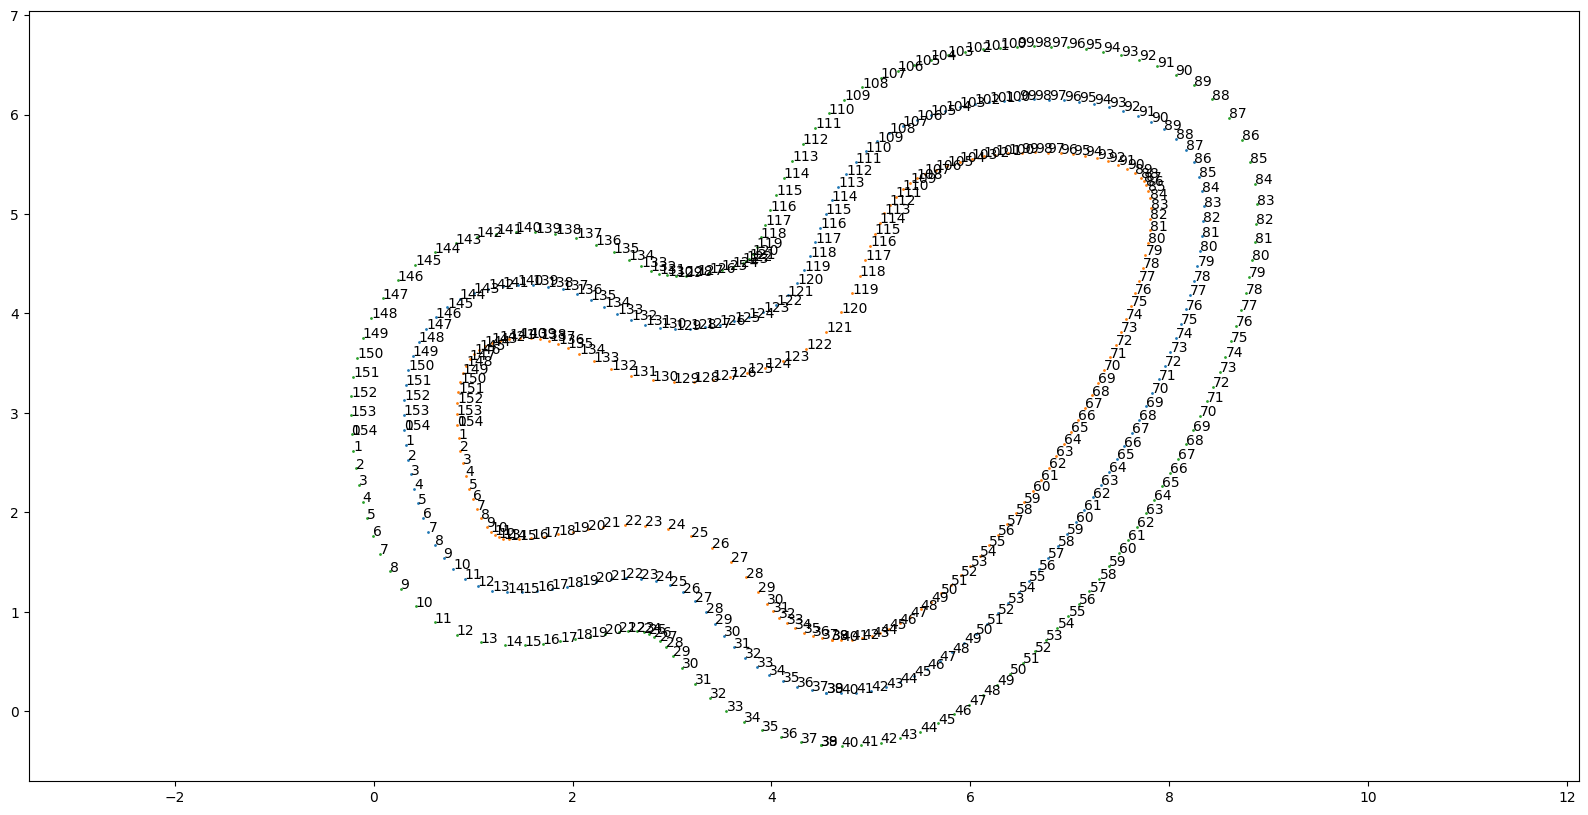

In [11]:
# We will try to guess the track name first, if it 
# fails, we'll use the constant in quotes

try:
    track_name = log.agent_and_network()["world"]
except Exception as e:
    track_name = "reInvent2019_track"


track: Track = tu.load_track(track_name)

pu.plot_trackpoints(track)

## Graphs

The original notebook has provided some great ideas on what could be visualised in the graphs. Below examples are a slightly extended version. Let's have a look at what they are presenting and what this may mean to your training.

### Training progress

As you have possibly noticed by now, training episodes are grouped into iterations and this notebook also reflects it. What also marks it are checkpoints in the training. After each iteration a set of ckpt files is generated - they contain outcomes of the training, then a model.pb file is built based on that and the car begins a new iteration. Looking at the data grouped by iterations may lead you to a conclusion, that some earlier checkpoint would be a better start for a new training. While this is limited in the AWS DeepRacer Console, with enough disk space you can keep all the checkpoints along the way and use one of them as a start for new training (or even as a submission to a race).

While the episodes in a given iteration are a mixture of decision process and random guesses, mean results per iteration may show a specific trend. Mean values are accompanied by standard deviation to show the concentration of values around the mean.

#### Rewards per Iteration

You can see these values as lines or dots per episode in the AWS DeepRacer console. When the reward goes up, this suggests that a car is learning and improving with regards to a given reward function. **This does not have to be a good thing.** If your reward function rewards something that harms performance, your car will learn to drive in a way that will make results worse.

At first the rewards just grow if the progress achieved grows. Interesting things may happen slightly later in the training:

* The reward may go flat at some level - it might mean that the car can't get any better. If you think you could still squeeze something better out of it, review the car's progress and consider updating the reward function, the action space, maybe hyperparameters, or perhaps starting over (either from scratch or from some previous checkpoint)
* The reward may become wobbly - here you will see it as a mesh of dots zig-zagging. It can be a gradually growing zig-zag or a roughly stagnated one. This usually means the learning rate hyperparameter is too high and the car started doing actions that oscilate around some local extreme. You can lower the learning rate and hope to step closer to the extreme. Or run away from it if you don't like it
* The reward plunges to near zero and stays roughly flat - I only had that when I messed up the hyperparameters or the reward function. Review recent changes and start training over or consider starting from scratch

The Standard deviation says how close from each other the reward values per episode in a given iteration are. If your model becomes reasonably stable and worst performances become better, at some point the standard deviation may flat out or even decrease. That said, higher speeds usually mean there will be areas on track with higher risk of failure. This may bring the value of standard deviation to a higher value and regardless of whether you like it or not, you need to accept it as a part of fighting for significantly better times.

#### Time per iteration

I'm not sure how useful this graph is. I would worry if it looked very similar to the reward graph - this could suggest that slower laps will be getting higher rewards. But there is a better graph for spotting that below.

#### Progress per Iteration

This graph usually starts low and grows and at some point it will get flatter. The maximum value for progress is 100% so it cannot grow without limits. It usually shows similar initial behaviours to reward and time graphs. I usually look at it when I alter an action in training. In such cases this graph usually dips a bit and then returns or goes higher.

#### Total reward per episode

This graph has been taken from the original notebook and can show progress on certain groups of behaviours. It usually forms something like a triangle, sometimes you can see a clear line of progress that shows some new way has been first taught and then perfected.

#### Mean completed lap times per iteration

Once we have a model that completes laps reasonably often, we might want to know how fast the car gets around the track. This graph will show you that. I use it quite often when looking for a model to shave a couple more miliseconds. That said it has to go in pair with the last one:

#### Completion rate per iteration

It represents how big part of all episodes in an iteration is full laps. The value is from range [0, 1] and is a result of dividing amount of full laps in iteration by amount of all episodes in iteration. I say it has to go in pair with the previous one because you not only need a fast lapper, you also want a race completer.

The higher the value, the more stable the model is on a given track.

new reward not found, using reward as its values
Multiple workers have been detected, reloading data with grouping by unique_episode
Grouping by 'unique_episode'
Number of episodes =  2719
Number of iterations =  135


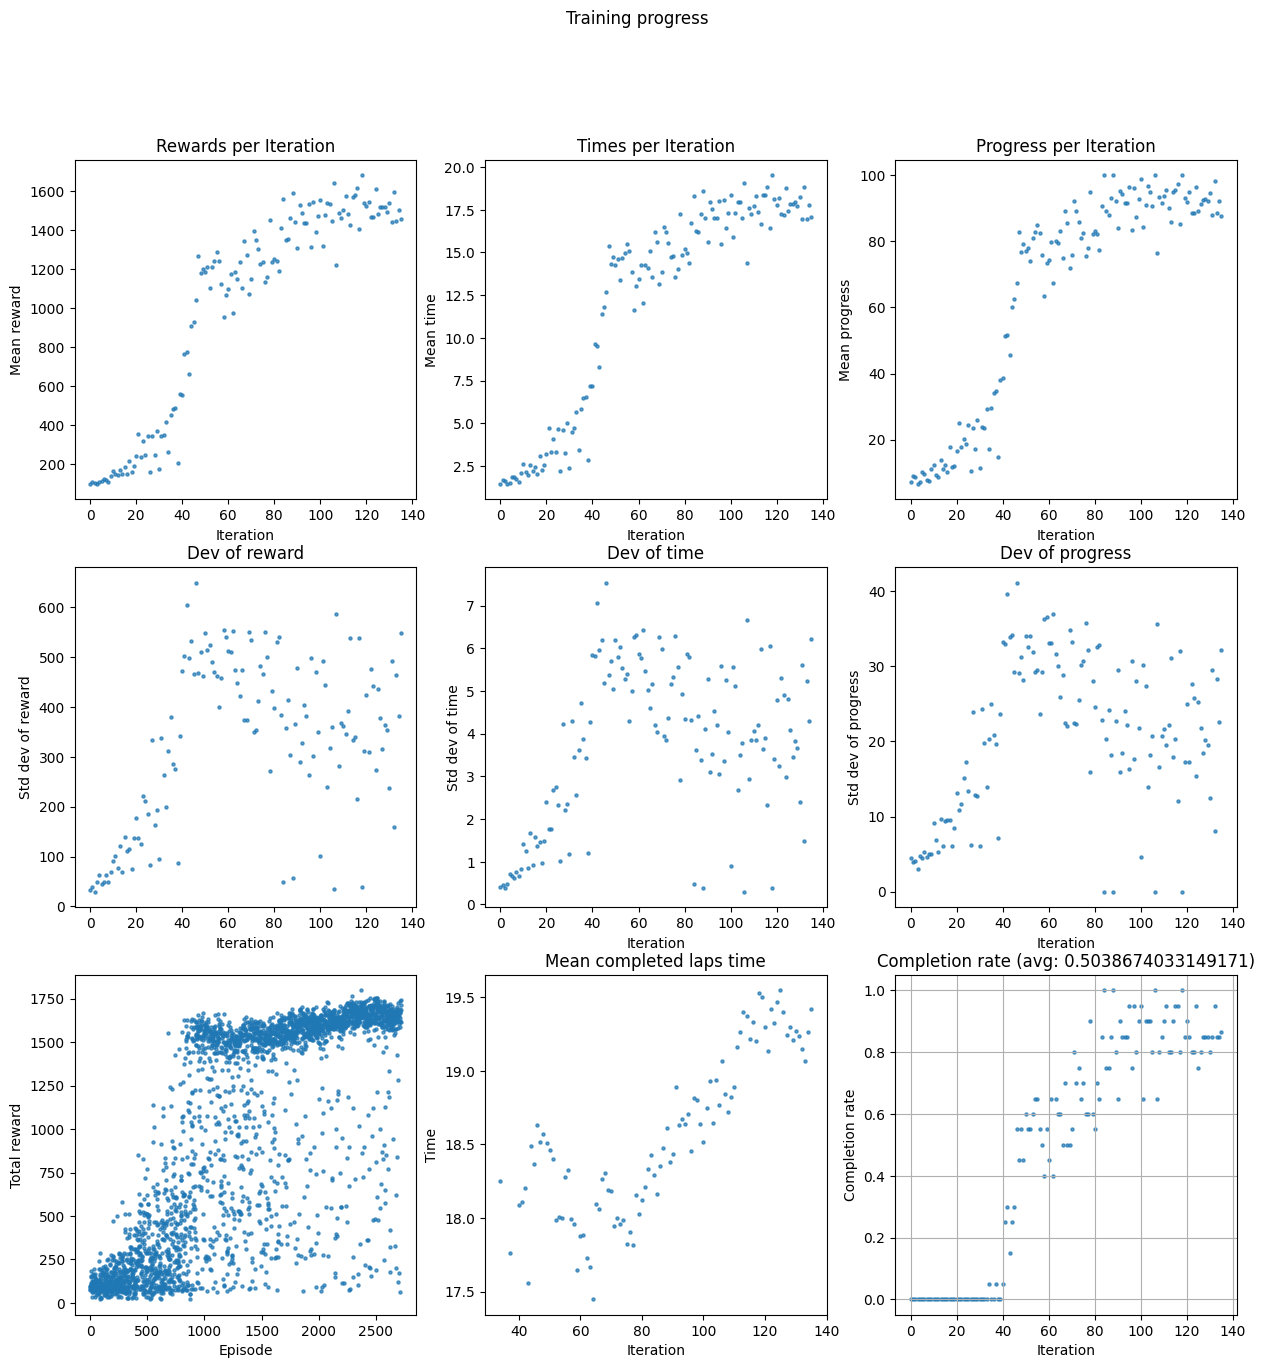

<Figure size 640x480 with 0 Axes>

In [12]:
simulation_agg = au.simulation_agg(df)
try: 
    if df.nunique(axis=0)['worker'] > 1:
        print("Multiple workers have been detected, reloading data with grouping by unique_episode")
        simulation_agg = au.simulation_agg(df, secondgroup="unique_episode")
except:
    print("Multiple workers not detected, assuming 1 worker")

au.analyze_training_progress(simulation_agg, title='Training progress')

### Stats for all laps

Previous graphs were mainly focused on the state of training with regards to training progress. This however will not give you a lot of information about how well your reward function is doing overall.

In such case `scatter_aggregates` may come handy. It comes with three types of graphs:
* progress/steps/reward depending on the time of an episode - of this I find reward/time and new_reward/time especially useful to see that I am rewarding good behaviours - I expect the reward to time scatter to look roughly triangular
* histograms of time and progress - for all episodes the progress one is usually quite handy to get an idea of model's stability
* progress/time_if_complete/reward to closest waypoint at start - these are really useful during training as they show potentially problematic spots on track. It can turn out that a car gets best reward (and performance) starting at a point that just cannot be reached if the car starts elsewhere, or that there is a section of a track that the car struggles to get past and perhaps it's caused by an aggressive action space or undesirable behaviour prior to that place

Side note: `time_if_complete` is not very accurate and will almost always look better for episodes closer to 100% progress than in case of those 50% and below.

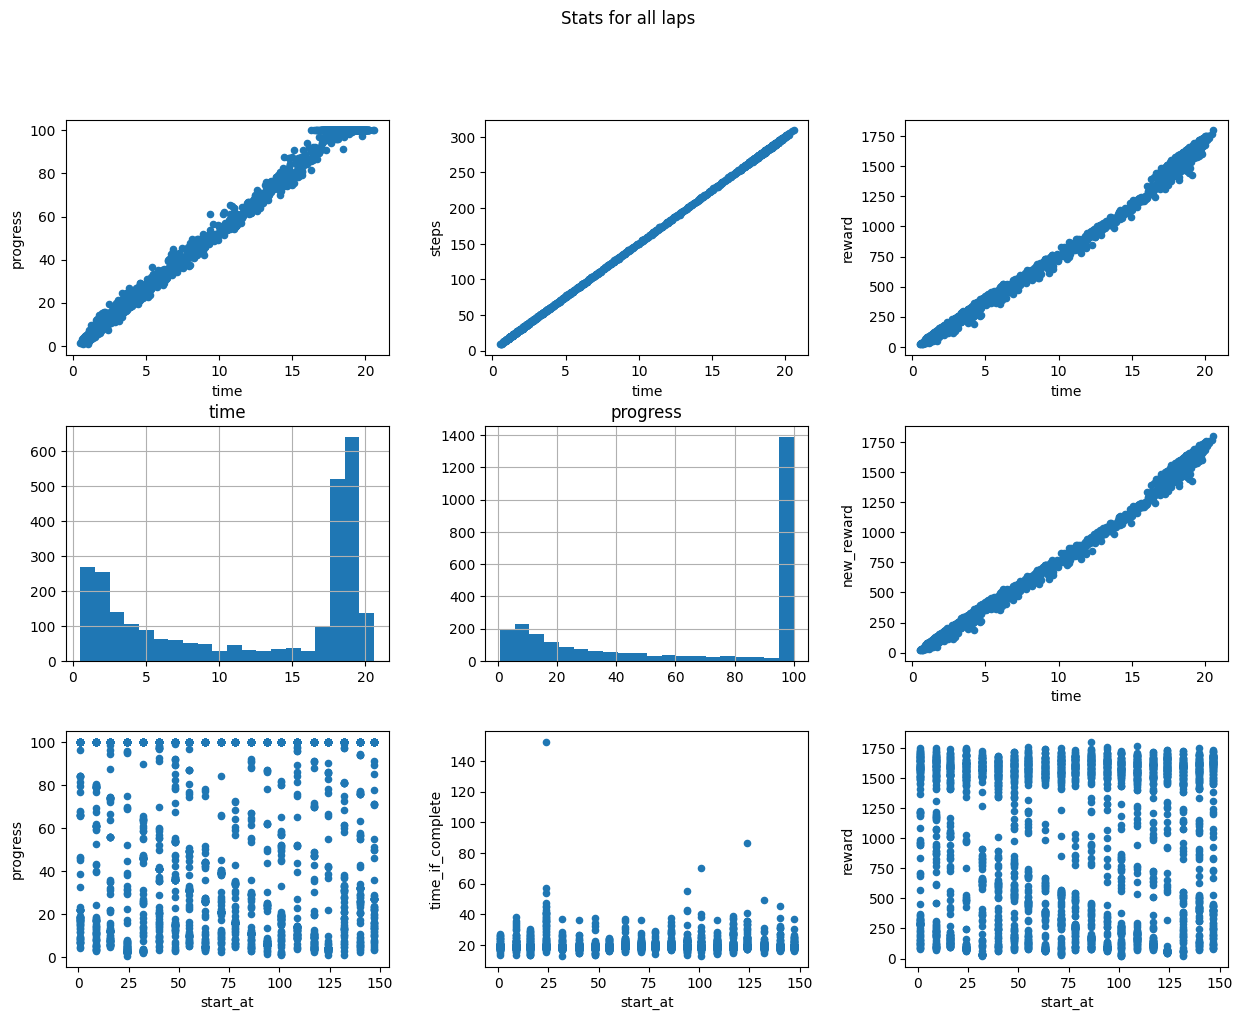

<Figure size 640x480 with 0 Axes>

In [13]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

### Stats for complete laps
The graphs here are same as above, but now I am interested in other type of information:
* does the reward scatter show higher rewards for lower completion times? If I give higher reward for a slower lap it might suggest that I am training the car to go slow
* what does the time histogram look like? With enough samples available the histogram takes a normal distribution graph shape. The lower the mean value, the better the chance to complete a fast lap consistently. The longer the tails, the greater the chance of getting lucky in submissions
* is the car completing laps around the place where the race lap starts? Or does it only succeed if it starts in a place different to the racing one?

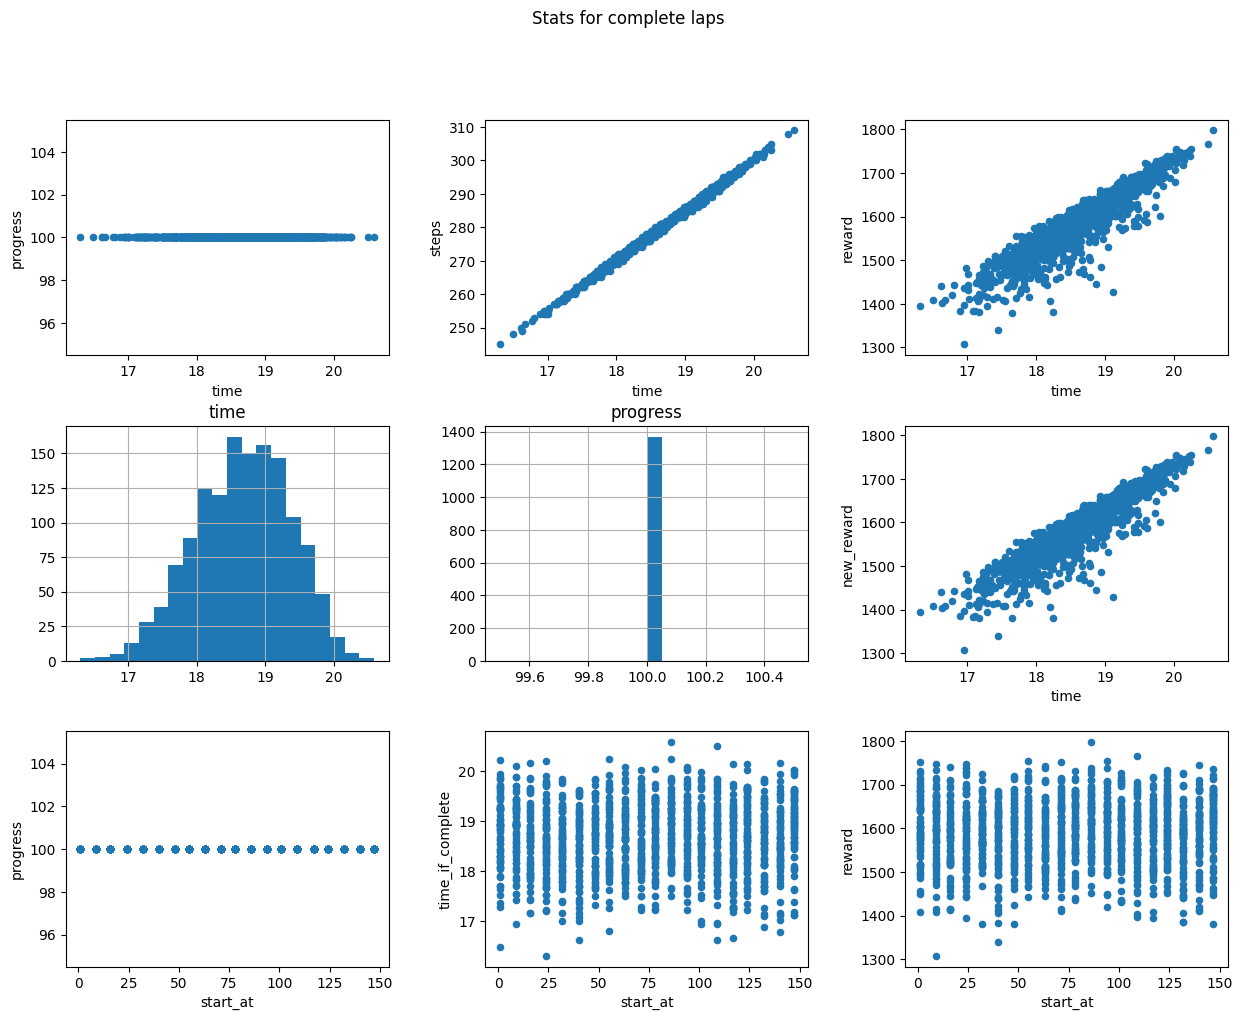

<Figure size 640x480 with 0 Axes>

In [14]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

### Categories analysis
We're going back to comparing training results based on the training time, but in a different way. Instead of just scattering things in relation to iteration or episode number, this time we're grouping episodes based on a certaing information. For this we use function:
```
analyze_categories(panda, category='quintile', groupcount=5, title=None)
```
The idea is pretty simple - determine a way to cluster the data and provide that as the `category` parameter (alongside the count of groups available). In the default case we take advantage of the aggregated information to which quintile an episode belongs and thus build buckets each containing 20% of episodes which happened around the same time during the training. If your training lasted for five hours, this would show results grouped per each hour.

A side note: if you run the function with `category='start_at'` and `groupcount=20` you will get results based on the waypoint closest to the starting point of an episode. If you need to, you can introduce other types of categories and reuse the function.

The graphs are similar to what we've seen above. I especially like the progress one which shows where the model tends to struggle and whether it's successful laps rate is improving or beginning to decrease. Interestingly, I also had cases where I saw the completion drop on the progress rate only to improve in a later quintile, but with a better time graph.

A second side note: if you run this function for `complete_ones` instead of `simulation_agg`, suddenly the time histogram becomes more interesting as you can see whether completion times improve.

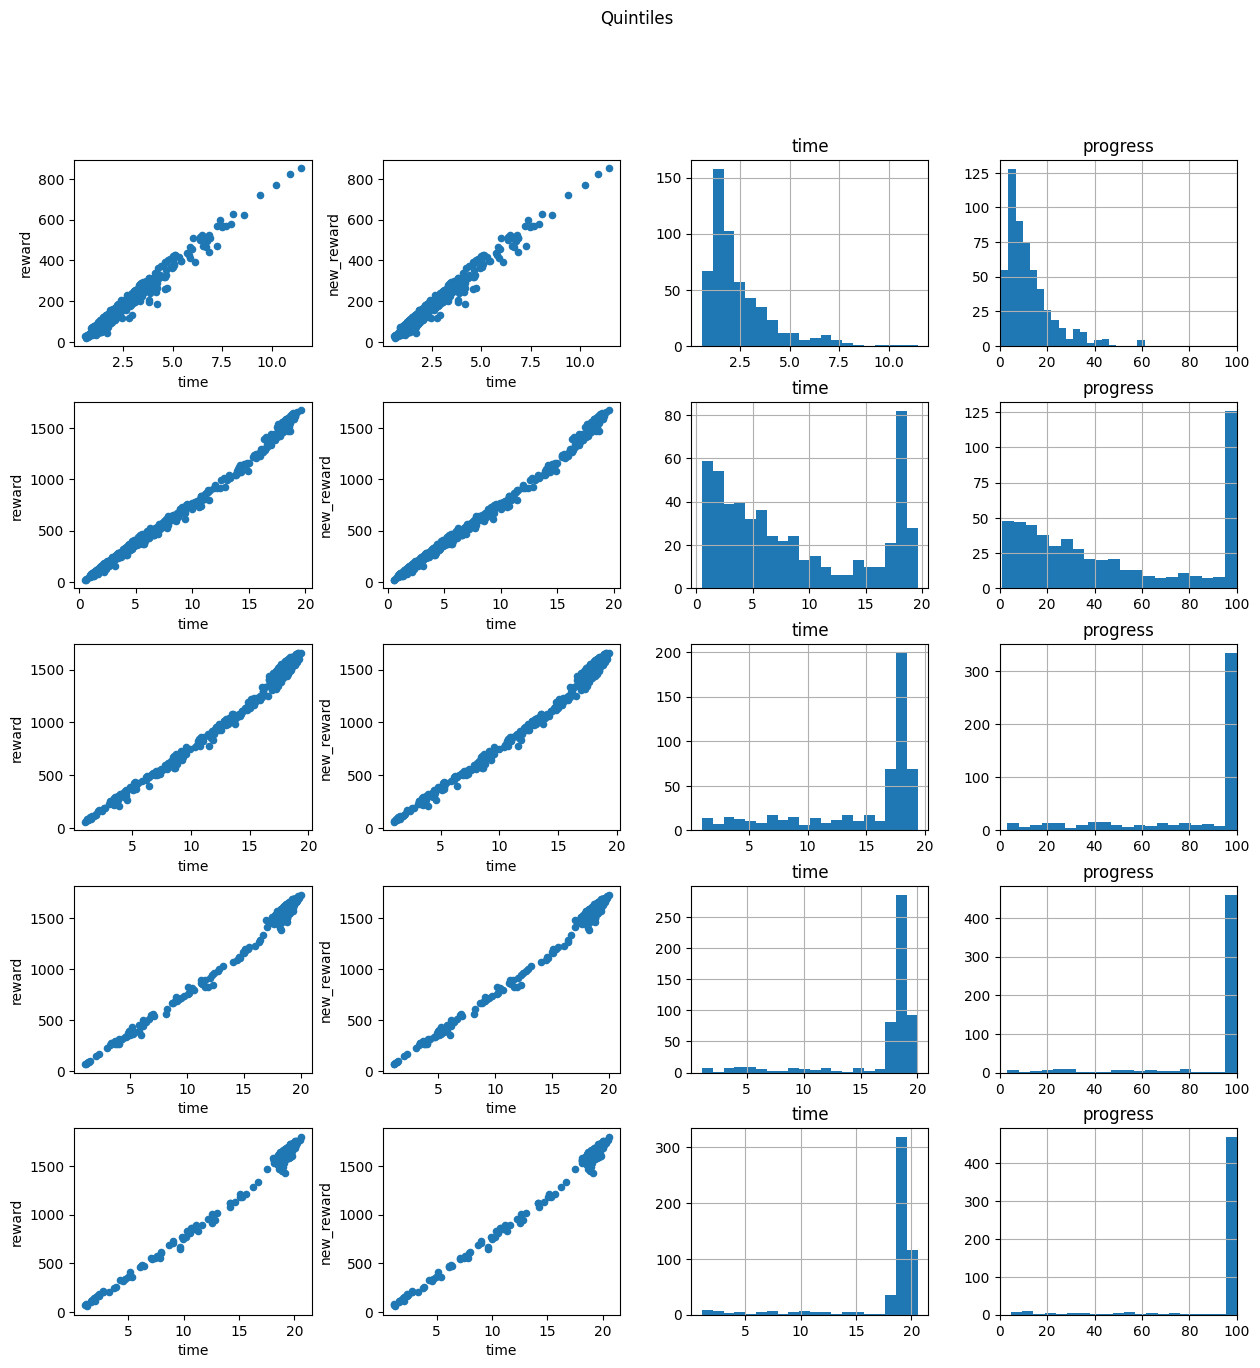

<Figure size 640x480 with 0 Axes>

In [15]:
au.scatter_by_groups(simulation_agg, title='Quintiles')

## Data in tables

While a lot can be seen in graphs that cannot be seen in the raw numbers, the numbers let us get into more detail. Below you will find a couple examples. If your model is behaving the way you would like it to, below tables may provide little added value, but if you struggle to improve your car's performance, they may come handy. In such cases I look for examples where high reward is giving to below-expected episode and when good episodes are given low reward.

You can then take the episode number and scatter it below, and also look at reward given per step - this can in turn draw your attention to some rewarding anomalies and help you detect some unexpected outcomes in your reward function.

There is a number of ways to select the data for display:
* `nlargest`/`nsmallest` lets you display information based on a specific value being highest or lowest
* filtering based on a field value, for instance `df[df['episode']==10]` will display only those steps in `df` which belong to episode 10
* `head()` lets you peek into a dataframe

There isn't a right set of tables to display here and the ones below may not suit your needs. Get to know Pandas more and have fun with them. It's almost as addictive as DeepRacer itself.

The examples have a short comment next to them explaining what they are showing.

In [16]:
# View ten best rewarded episodes in the training
simulation_agg.nlargest(10, 'new_reward')

iteration  unique_episode  steps  start_at  progress    time       dist  \
2366        118            2366  309.0        86     100.0  20.577  22.292990   
2294        114            2294  308.0       109     100.0  20.494  22.607129   
2507        125            2507  305.0        55     100.0  20.245  22.652215   
2452        122            2452  302.0        94     100.0  20.035  22.185494   
2509        125            2509  301.0        71     100.0  20.030  22.394462   
2490        124            2490  304.0         1     100.0  20.226  22.533144   
2486        124            2486  302.0         9     100.0  20.096  22.420363   
2488        124            2488  304.0        24     100.0  20.206  22.572624   
2713        135            2718  303.0       140     100.0  20.160  22.292690   
2433        121            2433  302.0        63     100.0  20.089  22.419412   

       new_reward     speed       reward  time_if_complete  \
2366  1797.537998  1.179612  1797.537998            20.577   
2294  1765.795332  1.243506  1765.795332            20.494   
2507  1754.510849  1.275410  1754.510849            20.245   
2452  1754.204033  1.243377  1754.204033            20.035   
2509  1751.988489  1.284053  1751.988489            20.030   
2490  1751.291170  1.231908  1751.291170            20.226   
2486  1747.891128  1.233444  1747.891128            20.096   
2488  1747.520709  1.305921  1747.520709            20.206   
2713  1745.358524  1.212871  1745.358524            20.160   
2433  1742.559085  1.302980  1742.559085            20.089   

      reward_if_complete quintile  complete  
2366         1797.537998      5th         1  
2294         1765.795332      5th         1  
2507         1754.510849      5th         1  
2452         1754.204033      5th         1  
2509         1751.988489      5th         1  
2490         1751.291170      5th         1  
2486         1747.891128      5th         1  
2488         1747.520709      5th         1  
2713         1745.358524      5th         1  
2433         1742.559085      5th         1

In [17]:
# View five fastest complete laps
complete_ones.nsmallest(5, 'time')

iteration  unique_episode  steps  start_at  progress    time       dist  \
1048         52            1048  245.0        24     100.0  16.308  21.855512   
1040         52            1040  248.0         1     100.0  16.494  22.080550   
1545         77            1545  250.0        40     100.0  16.618  21.461612   
1339         66            1339  249.0       109     100.0  16.625  21.182528   
1515         75            1515  251.0       117     100.0  16.672  21.663298   

       new_reward     speed       reward  time_if_complete  \
1048  1394.193489  1.740816  1394.193489            16.308   
1040  1409.207950  1.689516  1409.207950            16.494   
1545  1441.224507  1.666000  1441.224507            16.618   
1339  1402.730109  1.572289  1402.730109            16.625   
1515  1409.021736  1.723108  1409.021736            16.672   

      reward_if_complete quintile  complete  
1048         1394.193489      2nd         1  
1040         1409.207950      2nd         1  
1545         1441.224507      3rd         1  
1339         1402.730109      3rd         1  
1515         1409.021736      3rd         1

In [18]:
# View five best rewarded completed laps
complete_ones.nlargest(5, 'reward')

iteration  unique_episode  steps  start_at  progress    time       dist  \
2366        118            2366  309.0        86     100.0  20.577  22.292990   
2294        114            2294  308.0       109     100.0  20.494  22.607129   
2507        125            2507  305.0        55     100.0  20.245  22.652215   
2452        122            2452  302.0        94     100.0  20.035  22.185494   
2509        125            2509  301.0        71     100.0  20.030  22.394462   

       new_reward     speed       reward  time_if_complete  \
2366  1797.537998  1.179612  1797.537998            20.577   
2294  1765.795332  1.243506  1765.795332            20.494   
2507  1754.510849  1.275410  1754.510849            20.245   
2452  1754.204033  1.243377  1754.204033            20.035   
2509  1751.988489  1.284053  1751.988489            20.030   

      reward_if_complete quintile  complete  
2366         1797.537998      5th         1  
2294         1765.795332      5th         1  
2507         1754.510849      5th         1  
2452         1754.204033      5th         1  
2509         1751.988489      5th         1

In [19]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5, 'new_reward')

iteration  unique_episode  steps  start_at  progress    time       dist  \
2366        118            2366  309.0        86     100.0  20.577  22.292990   
2294        114            2294  308.0       109     100.0  20.494  22.607129   
2507        125            2507  305.0        55     100.0  20.245  22.652215   
2452        122            2452  302.0        94     100.0  20.035  22.185494   
2509        125            2509  301.0        71     100.0  20.030  22.394462   

       new_reward     speed       reward  time_if_complete  \
2366  1797.537998  1.179612  1797.537998            20.577   
2294  1765.795332  1.243506  1765.795332            20.494   
2507  1754.510849  1.275410  1754.510849            20.245   
2452  1754.204033  1.243377  1754.204033            20.035   
2509  1751.988489  1.284053  1751.988489            20.030   

      reward_if_complete quintile  complete  
2366         1797.537998      5th         1  
2294         1765.795332      5th         1  
2507         1754.510849      5th         1  
2452         1754.204033      5th         1  
2509         1751.988489      5th         1

In [20]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

iteration  unique_episode  steps  start_at  progress    time       dist  \
680         34             680  274.0        78     100.0  18.250  22.023004   
741         37             741  267.0        48     100.0  17.760  22.195198   
800         40             800  272.0         1     100.0  18.090  21.890459   
821         41             821  286.0        48     100.0  19.046  22.928336   
829         41             829  262.0        71     100.0  17.516  21.769610   

      new_reward     speed       reward  time_if_complete  reward_if_complete  \
680  1551.182210  1.503650  1551.182210            18.250         1551.182210   
741  1424.286405  1.679775  1424.286405            17.760         1424.286405   
800  1557.348672  1.512868  1557.348672            18.090         1557.348672   
821  1626.666048  1.582168  1626.666048            19.046         1626.666048   
829  1409.363111  1.509542  1409.363111            17.516         1409.363111   

    quintile  complete  
680      2nd         1  
741      2nd         1  
800      2nd         1  
821      2nd         1  
829      2nd         1

In [21]:
# View information for a couple first episodes
simulation_agg.head()

iteration  unique_episode  steps  start_at   progress   time      dist  \
0          0               0   22.0         1   7.187600  1.379  1.995317   
1          0               1   18.0         9   4.145729  1.105  1.376358   
2          0               2   20.0        16   6.333345  1.261  1.740339   
3          0               3   15.0        24   2.030019  0.926  1.003328   
4          0               4   32.0        32  11.698993  2.065  2.696685   

   new_reward     speed      reward  time_if_complete  reward_if_complete  \
0   95.497086  3.113636   95.497086         19.185820         1328.636635   
1   78.072304  2.750000   78.072304         26.653934         1883.198218   
2   94.272544  2.650000   94.272544         19.910490         1488.511144   
3   71.531528  1.900000   71.531528         45.615341         3523.687936   
4  115.376103  2.359375  115.376103         17.651093          986.205458   

  quintile  complete  
0      1st         0  
1      1st         0  
2      1st         0  
3      1st         0  
4      1st         0

In [22]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==10]

episode  steps         x         y     heading  steering_angle  speed  \
971        10    1.0  8.525907  4.326998   75.129486            15.0    4.0   
972        10    2.0  8.525770  4.327114   75.201198             0.0    4.0   
973        10    3.0  8.528629  4.336136   75.022540            30.0    4.0   
974        10    4.0  8.531798  4.351486   75.093777            15.0    2.5   
975        10    5.0  8.530092  4.388543   77.650458             0.0    2.5   
976        10    6.0  8.529950  4.440437   80.220097            22.5    1.0   
977        10    7.0  8.530067  4.505325   82.587387            30.0    2.5   
978        10    8.0  8.507259  4.607792   90.409733            -7.5    2.5   
979        10    9.0  8.488850  4.668579   94.649583            -7.5    1.0   
980        10   10.0  8.480906  4.751735   95.597546            -7.5    1.0   
981        10   11.0  8.478860  4.811709   94.773767            22.5    4.0   
982        10   12.0  8.470783  4.910570   94.906410             7.5    4.0   
983        10   13.0  8.423284  5.045203  102.103035            30.0    4.0   
984        10   14.0  8.354011  5.168264  110.790733            15.0    1.0   
985        10   15.0  8.312952  5.223173  116.075610           -30.0    1.0   
986        10   16.0  8.252838  5.300850  123.771392            22.5    4.0   
987        10   17.0  8.155803  5.426142  131.555427            15.0    1.0   
988        10   18.0  8.111727  5.467308  135.959958             7.5    2.5   
989        10   19.0  7.999521  5.546542  147.190723            -7.5    2.5   
990        10   20.0  7.910048  5.588478  155.308354             7.5    1.0   
991        10   21.0  7.788883  5.629006  165.799768            22.5    4.0   
992        10   22.0  7.653173  5.655320  178.842824            -7.5    4.0   
993        10   23.0  7.576370  5.660693 -174.730159             0.0    2.5   
994        10   24.0  7.419213  5.646955 -161.263081            22.5    1.0   
995        10   25.0  7.317916  5.626615 -152.476599             0.0    4.0   
996        10   26.0  7.205573  5.599288 -147.602249            -7.5    2.5   
997        10   27.0  7.071213  5.537442 -140.775034           -30.0    4.0   
998        10   28.0  6.957970  5.481020 -138.406010           -30.0    4.0   
999        10   29.0  6.786373  5.416701 -143.869997           -22.5    4.0   
1000       10   30.0  6.626848  5.372897 -154.645149             0.0    2.5   
1106       10    1.0  8.525935  4.327048   75.093682            30.0    1.0   
1107       10    2.0  8.525943  4.326948   75.099211           -22.5    2.5   
1108       10    3.0  8.528134  4.334035   75.091788            22.5    1.0   
1109       10    4.0  8.524280  4.358118   77.591455             7.5    1.0   
1110       10    5.0  8.522641  4.392388   79.698357            15.0    2.5   
1111       10    6.0  8.519813  4.437058   82.266972             0.0    4.0   
1112       10    7.0  8.515604  4.491498   84.930619           -30.0    2.5   
1113       10    8.0  8.525379  4.552800   84.049365           -15.0    2.5   
1114       10    9.0  8.588016  4.704938   74.888722           -30.0    1.0   
1115       10   10.0  8.609330  4.741129   72.054262           -30.0    2.5   
1116       10   11.0  8.682912  4.842718   63.812813            22.5    4.0   
1117       10   12.0  8.738259  4.911316   59.561029            30.0    2.5   
1118       10   13.0  8.778612  4.979874   59.346810            15.0    1.0   
1119       10   14.0  8.845091  5.135310   63.692057            30.0    2.5   
1120       10   15.0  8.879204  5.241126   67.274937            30.0    4.0   
1121       10   16.0  8.905662  5.393747   74.221368           -15.0    1.0   
1122       10   17.0  8.914703  5.503846   80.580527            -7.5    1.0   
1123       10   18.0  8.937262  5.630041   82.666888             7.5    2.5   
1124       10   19.0  8.969746  5.808633   81.752393            -7.5    4.0   
1220       10    1.0  8.525969  4.327119   75.111946    

## Analyze the reward distribution for your reward function

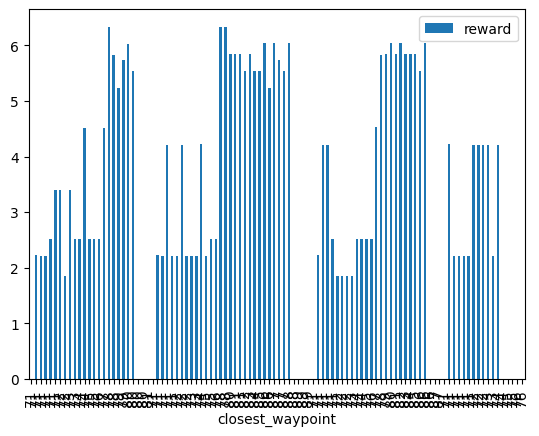

In [23]:
# This shows a histogram of actions per closest waypoint for episode 889.
# Will let you spot potentially problematic places in reward granting.
# In this example reward function is clearly `return 1`. It may be worrying
# if your reward function has some logic in it.
# If you have a final step reward that makes the rest of this histogram
# unreadable, you can filter the last step out by using
# `episode[:-1].plot.bar` instead of `episode.plot.bar`
episode = df[df['episode']==9]

if episode.empty:
    print("You probably don't have episode with this number, try a lower one.")
else:
    episode.plot.bar(x='closest_waypoint', y='reward')

### Path taken for top reward iterations

NOTE: at some point in the past in a single episode the car could go around multiple laps, the episode was terminated when car completed 1000 steps. Currently one episode has at most one lap. This explains why you can see multiple laps in an episode plotted below.

Being able to plot the car's route in an episode can help you detect certain patterns in its behaviours and either promote them more or train away from them. While being able to watch the car go in the training gives some information, being able to reproduce it after the training is much more practical.

Graphs below give you a chance to look deeper into your car's behaviour on track.

We start with plot_selected_laps. The general idea of this block is as follows:
* Select laps(episodes) that have the properties that you care about, for instance, fastest, most progressed, failing in a certain section of the track or not failing in there,
* Provide the list of them in a dataframe into the plot_selected_laps, together with the whole training dataframe and the track info,
* You've got the laps to analyse.

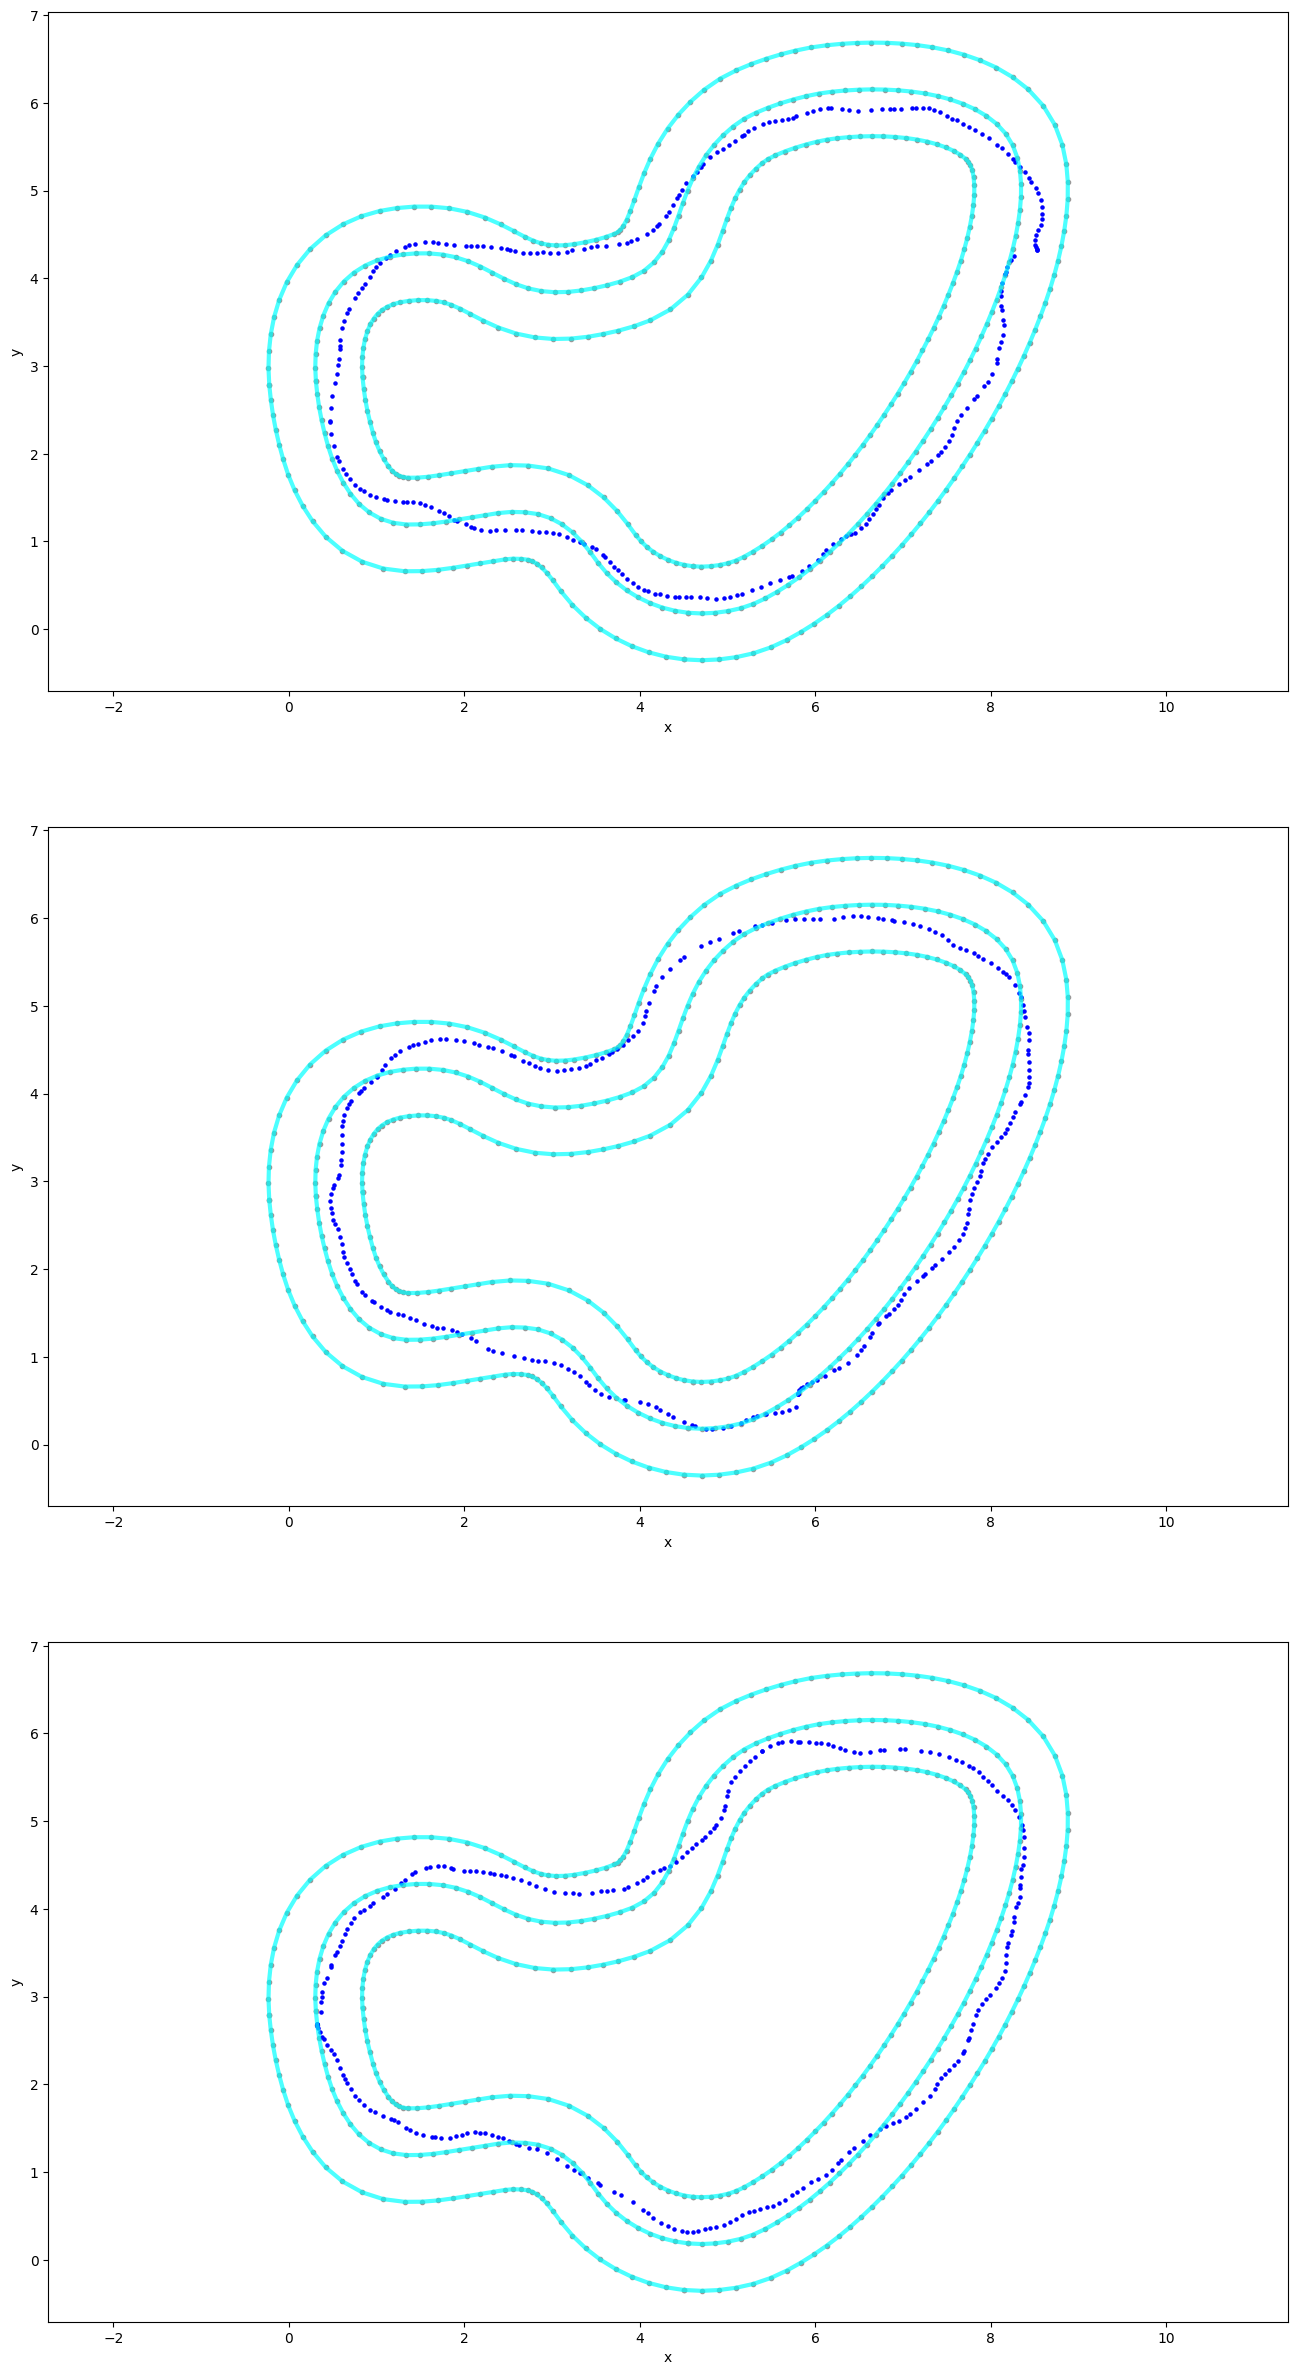

<Figure size 640x480 with 0 Axes>

In [24]:
# Some examples:
# highest reward for complete laps:
# episodes_to_plot = complete_ones.nlargest(3,'reward')

# highest progress from all episodes:
episodes_to_plot = simulation_agg.nlargest(3,'progress')

try:
    if df.nunique(axis=0)['worker'] > 1:
        pu.plot_selected_laps(episodes_to_plot, df, track, section_to_plot="unique_episode")
    else:
        pu.plot_selected_laps(episodes_to_plot, df, track)
except:
    print("Multiple workers not detected, assuming 1 worker")
    pu.plot_selected_laps(episodes_to_plot, df, track)

### Plot a heatmap of rewards for current training. 
The brighter the colour, the higher the reward granted in given coordinates.
If instead of a similar view as in the example below you get a dark image with hardly any 
dots, it might be that your rewards are highly disproportionate and possibly sparse.

Disproportion means you may have one reward of 10.000 and the rest in range 0.01-1.
In such cases the vast majority of dots will simply be very dark and the only bright dot
might be in a place difficult to spot. I recommend you go back to the tables and show highest
and average rewards per step to confirm if this is the case. Such disproportions may
not affect your traning very negatively, but they will make the data less readable in this notebook.

Sparse data means that the car gets a high reward for the best behaviour and very low reward
for anything else, and worse even, reward is pretty much discrete (return 10 for narrow perfect,
else return 0.1). The car relies on reward varying between behaviours to find gradients that can
lead to improvement. If that is missing, the model will struggle to improve.

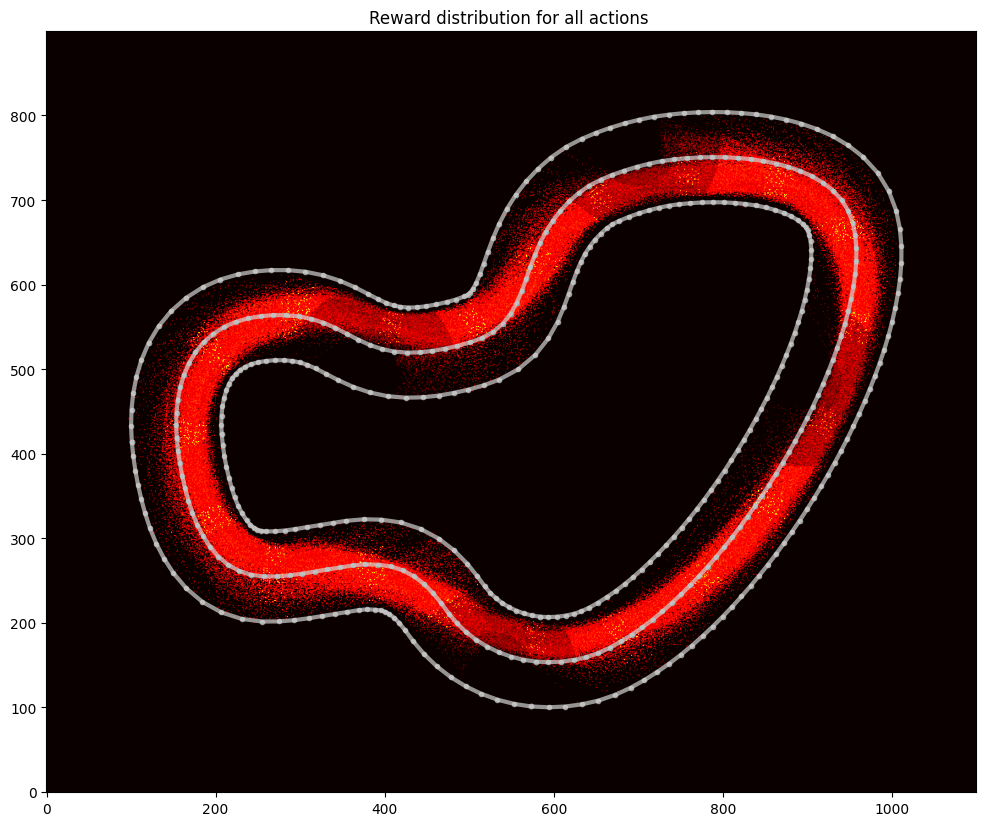

<Figure size 640x480 with 0 Axes>

In [25]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column

pu.plot_track(df, track)

### Plot a particular iteration
This is same as the heatmap above, but just for a single iteration.

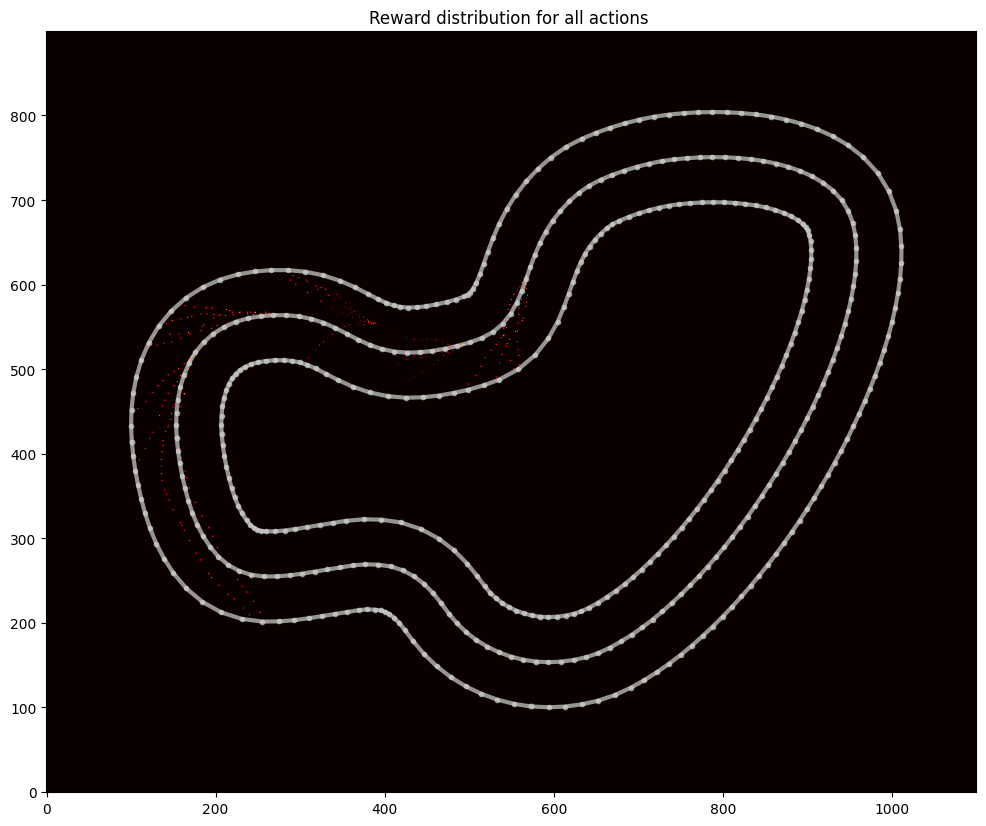

<Figure size 640x480 with 0 Axes>

In [26]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column
iteration_id = 3

pu.plot_track(df[df['iteration'] == iteration_id], track)

### Path taken in a particular episode

In [27]:
episode_id = 12

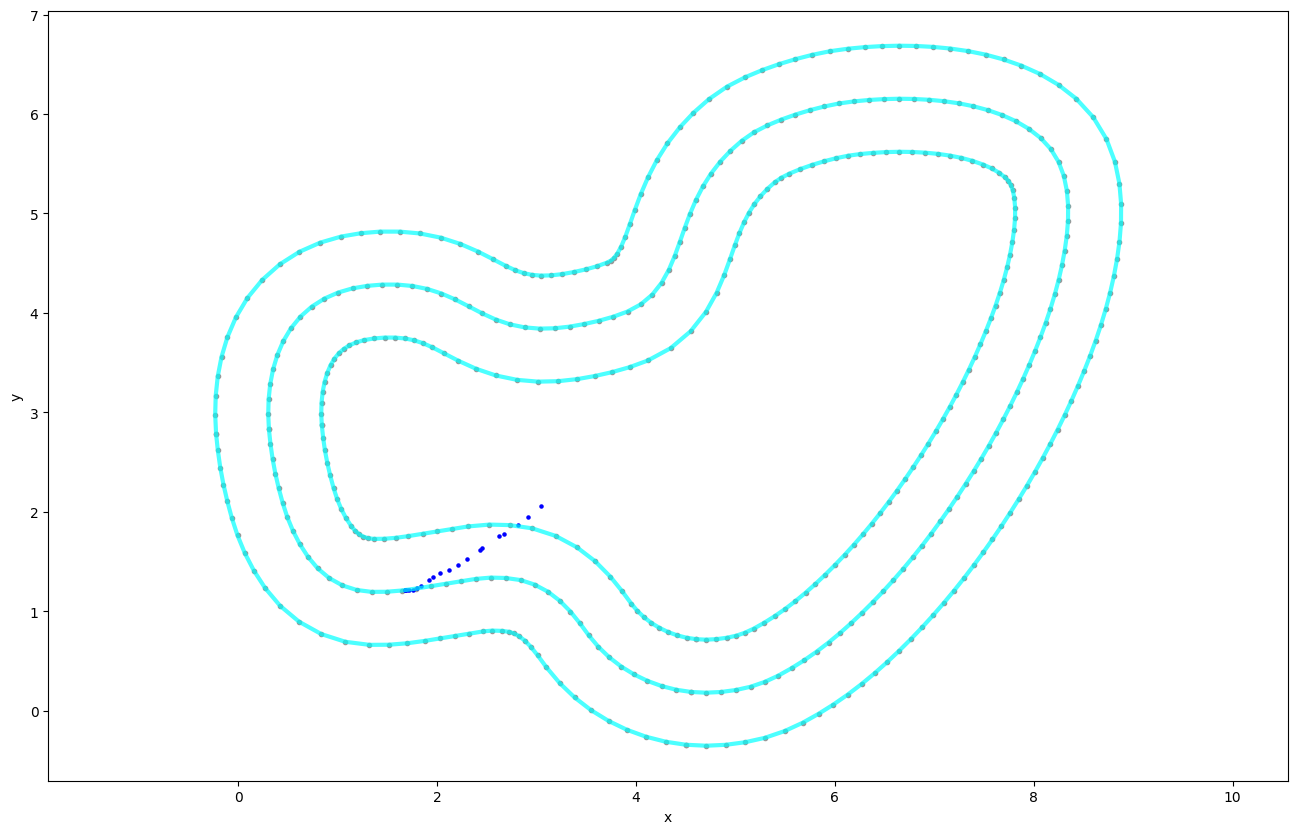

<Figure size 640x480 with 0 Axes>

In [28]:
try:
    if df.nunique(axis=0)['worker'] > 1:
        pu.plot_selected_laps([episode_id], df, track, section_to_plot="unique_episode")
    else: 
        pu.plot_selected_laps([episode_id], df, track)
except:
    print("Multiple workers not detected, assuming 1 worker")
    pu.plot_selected_laps([episode_id], df, track)

### Path taken in a particular iteration

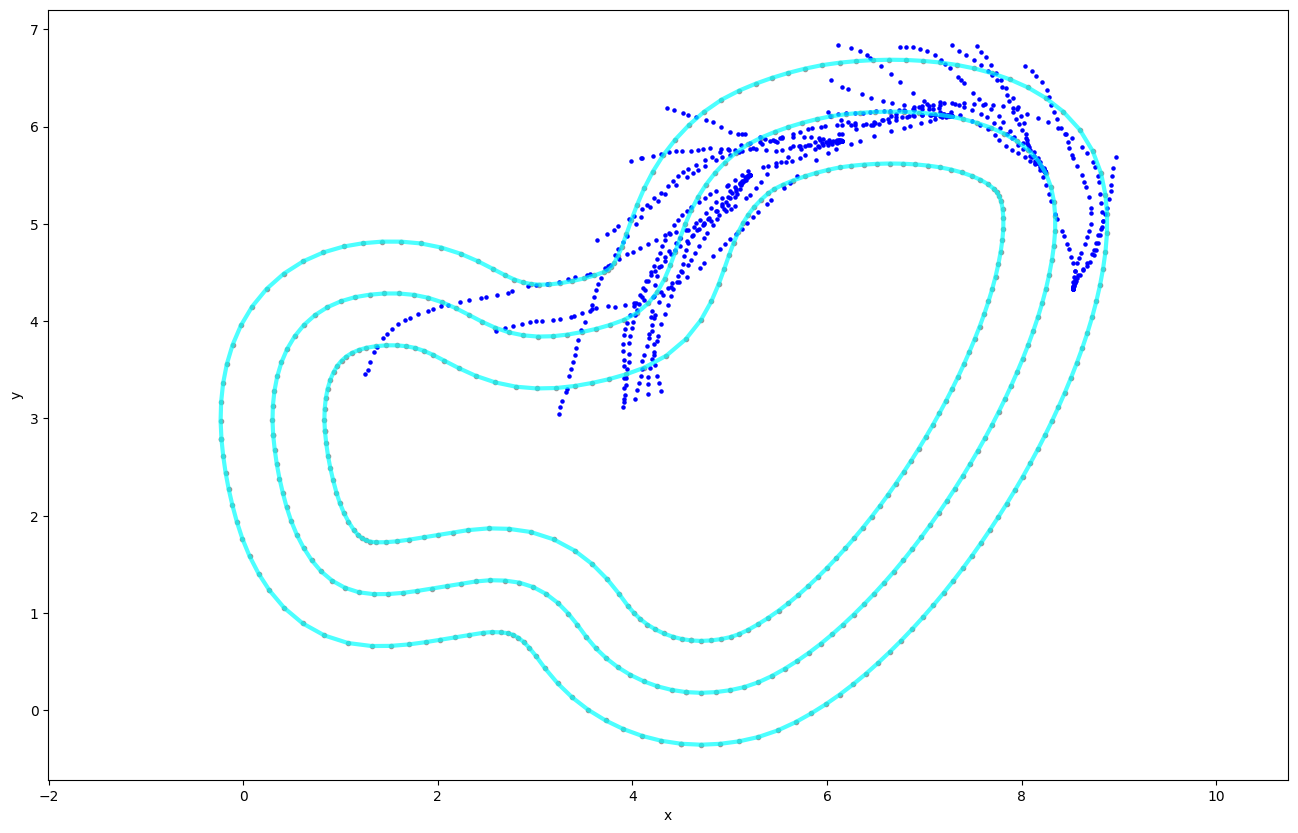

<Figure size 640x480 with 0 Axes>

In [29]:
iteration_id = 10

pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')

# Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration. Unfortunately at this time it is not fit for purpose as it assumes six actions in the action space and has other issues. It will require some work to get it to done but the information it returns will be very valuable.

This is a bit of an attempt to abstract away from the brilliant function in the original notebook towards a more general graph that we could use. It should be treated as a work in progress. The track_breakdown could be used as a starting point for a general track information object to handle all the customisations needed in methods of this notebook.

A breakdown track data needs to be available for it. If you cannot find it for the desired track, MAKEIT.

Currently supported tracks:

In [30]:
track_breakdown.keys()

dict_keys(['reinvent2018', 'london_loop'])

You can replace episode_ids with iteration_ids and make a breakdown for a whole iteration.

**Note: does not work for continuous action space (yet).** 

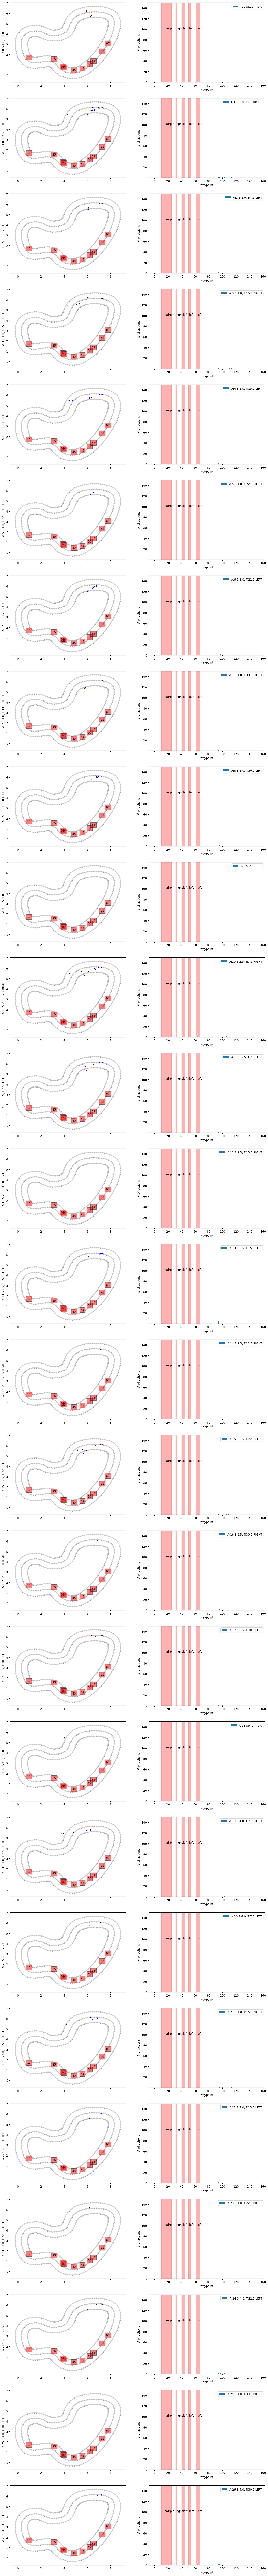

<Figure size 640x480 with 0 Axes>

In [31]:
abu.action_breakdown(df, track, track_breakdown=track_breakdown.get('reinvent2018'), episode_ids=[12])